# **Stable Diffusion** 🎨 
*...using* 🤗 *Huggingface `🧨diffusers`*

---

This is a slightly modified version of [this](https://github.com/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb) great notebook by Huggingface. 

Please **remember** to **collect interesting findings** (e.g., prompts and generated images, interesting websites, thoughts and questions, which you would like to share with the group, ...) in [this slide deck](https://docs.google.com/presentation/d/1n5P9JIyYoISbRIfRgXvwmXFdETlPm1FQ_S7WuqKgqBo/edit?usp=sharing).

---

Stable Diffusion is a text-to-image latent diffusion model created by the researchers and engineers from [CompVis](https://github.com/CompVis) (formerly at Heidelberg, now at LMU Munich), [Stability AI](https://stability.ai/) and [LAION](https://laion.ai/). 

It's trained on 512x512 images from a subset of the [LAION-5B](https://laion.ai/blog/laion-5b/) database. Feel free to take a moment and look at the great collection of text-and-image pairs, which these researchers have collected, e.g. via this [text-searchable interface to the dataset](https://rom1504.github.io/clip-retrieval/?back=https%3A%2F%2Fknn5.laion.ai&index=laion5B&useMclip=false&query=kitten+with+hat). However, please be aware that the dataset was directly crawled from the publicly accessible internet, thus it might also contain quite disturbing pictures.

With respect to this, please take also a minute and read the "Disclaimer on dataset purpose and content warning" on [LAION-5B](https://laion.ai/blog/laion-5b/) page. Reflect on your thoughts on training very powerful models on such an *uncurated* (i.e., no images were removed due to potentially disturbing or even illegal content) dataset, which was basically just downloaded from the publicly accessible internet.

The Stable Diffusion model uses a frozen CLIP ViT-L/14 text encoder to condition the image generation process on text prompts.

With its 860M parameter UNet and 123M parameter text encoder, the model is relatively lightweight and runs on a GPU with at least 10GB VRAM.
See the [model card](https://huggingface.co/CompVis/stable-diffusion) for more information.

This Colab notebook shows how to use Stable Diffusion with the 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers). 

Let's get started!

## 1. How to use `StableDiffusionPipeline`

Before diving into the theoretical aspects of how Stable Diffusion functions, 
let's try it out a bit 🤗.

In this section, we show how you can run text to image inference in just a few lines of code!

### Setup

The virtual machines, which power your Colab notebook come in different "flavors". Some of them only have CPUs (standard computer processors) and no additional GPUs (graphics cards). For the Stable-Diffusion notebooks to run, you always want to have a machine with a GPU. You can change the type of your "Runtime" via the "Runtime -> Change runtime type" (German: "Laufzeit -> Laufzeittyp ändern").

We use an exclamation mark to run a command directly on the virtual machine. Here, we execute nvidia-smi, which is a tool that checks for the presence of an NVIDIA graphics card. If it finds a card, it will print some info. However, if the following command fails, use the `Runtime` menu above and select `Change runtime type`.

In case a "This notebook requires extended RAM" message pops up, just click "Ok" and ignore it, the amount of RAM (random access memory) we have should be fine. :)

In [ ]:
!nvidia-smi

Next, you should install `diffusers==0.4.0` as well `scipy`, `ftfy` and `transformers`.

In [ ]:
!pip install diffusers==0.4.0
!pip install transformers scipy ftfy
!pip install "ipywidgets>=7,<8"

Some of the pre-trained models, which you can download from Huggingface, come with a license, which you first have to accept, before you can use them. These licences often come with models which are extremely powerful, so that the people sharing them want to make sure, that they are not used for commercial (or even malicious) purposes.

Stable-diffusion is one of these models. Thus, you also need to accept the model license before downloading or using the weights (i.e., the pre-trained network). In this post we'll use model version `v1-4`, so you'll need to  visit [its model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) while being logged in with your Hugging face account, read the license, and **tick the checkbox if you agree**. 

For this you have to be a registered user in 🤗 Hugging Face Hub.

To use your Hugging Face account from this notebook, you'll also need to create and use an access token, it replaces your Huggingface accountname and passwort, when logging in from Colab, which in turn helps to maintain your account and logging details safe and secure. 

You can create a token [here](https://huggingface.co/settings/tokens). Just click "New token", give the token a name (e.g., "diffusers"), select the "read" role (i.e., you cannot write data from a colab notebook to your Huggingface account, if you use this token), and click on "Generate a token". 

Et voila, a new token will appear, which you can "show" and then copy-paste to the login-window, which we will create using the next two code cells. 

Alternatively, you can directly click the two rectangles right next to the "Show" button and the token will directly be copied to your clipboard.

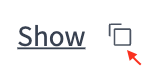

To show you the Huggingface Login window, we first need to enable external interactive elements in Colab. Run the following cell to be able to use `notebook_login`

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

Now you can login with your newly generated token to finally download the Stable-Diffusion model. For this, execute the next cell, then paste the token into the "Token" field and click the "Login" button.

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

### Stable Diffusion Pipeline

`StableDiffusionPipeline` is an end-to-end inference pipeline that you can use to generate images from text with just a few lines of code.

First, we load the pre-trained weights of all components of the model.

In addition to the model id [CompVis/stable-diffusion-v1-4](https://huggingface.co/CompVis/stable-diffusion-v1-4), we're also passing a specific `revision` and `torch_dtype` to the `from_pretrained` method.

Make sure you have created the login token with the same account, which you used to accept the model's license, so that it can be verified that you have indeed accepted the model's license.

We want to ensure that our free Google Colab instance does not run out of GPU memory, when running Stable Diffusion, hence we're loading the weights from the half-precision branch [`fp16`](https://huggingface.co/CompVis/stable-diffusion-v1-4/tree/fp16) and also tell `diffusers` to expect the weights in float16 precision by passing `torch_dtype=torch.float16`. This means that each individual weight is represented only using 16 bits (1s or 0s), instead of 32. This reduces a bit the quality of the samples, but at the same time also reduces the required amount of memory to store the model by half.

If you want to ensure the highest possible precision, please make sure to remove `revision="fp16"` and `torch_dtype=torch.float16` at the cost of a higher memory usage (which will probably not work with your free Colab instance).

In [ ]:
import torch
from diffusers import StableDiffusionPipeline

# make sure you're logged in with the right Huggingface token

# We will create a full Stable-Diffusion pipeline
# and just save it to the variable with the unassuming
# name 'pipe'
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", revision="fp16", torch_dtype=torch.float16)  

Next, let's move the pipeline to the graphics card to have faster inference. "CUDA" is the name of the proprietary libraries, which you an use to accelerate computations with NVIDIA graphics cards (which have an almost de-facto monopoly on GPUs for machine learning, another thing which warrants some critical reflection).

In [ ]:
pipe = pipe.to("cuda")

Now would be the time for a drumroll, as in the next cell you will generate your first image using the stable-diffusion model. Feel free to experiment with the prompt and the image dimensions.

In [ ]:
prompt = "a photograph of an astronaut riding a horse"

# We save the output of running our pipeline saved in the variable
# "pipe" with the prompt saved in the variable "prompt"
# in the variable results.
results = pipe(prompt)

# Let us have a look at this output
print(results)

We see, that results has the type *StableDiffusionPipelineOutput*. Furthermore, we see that this complex datatype has two so called "properties", which are called "images" and "nsfw_content_detected".
Both are lists ([...]) with one element. The single element of the list "images" is of the type PIL.Image.Image, which is a datatype containing (well, you guessed it) an image.
The second list just contains a boolean (yes/no) variable, which indicates, if here was nsfw ("not suited for work") content detected in the generated image. If this is "yes", images will just contain an all-black image.

To access the property of a complex "class", such as *StableDiffusionPipelineOutput*, we can just use the "." operator.

In [ ]:
# We can write results.images to access the "images" property of the
# class stored in results.
# However, we know, that this list only contains one image, so we can 
# directly access this image by writing:

image = results.images[0]

# Now to display an image you can do either save it such as:
image.save(f"astronaut_rides_horse.png")

# or if you're in a google colab you can directly display it with 
image

Note that by clicking the folder icon on the left, 

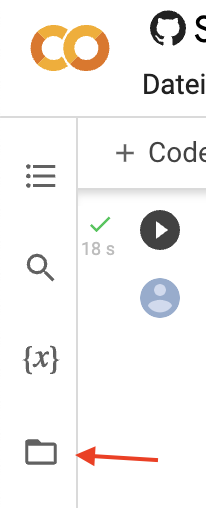

you can open a file browser, which shows you the content of the current working directory on your Colab machine. 

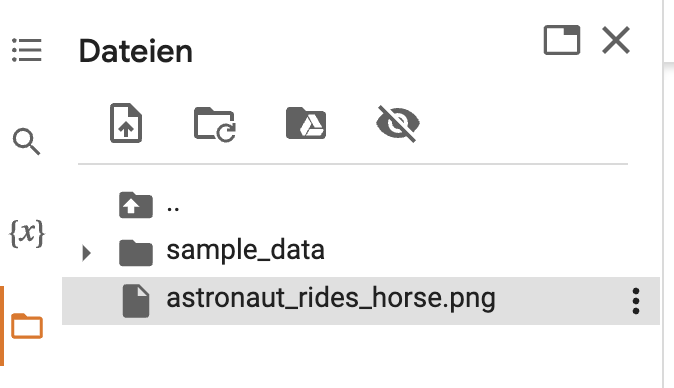

From there, you can download files via right-clicking or by clicking on the three dots which appear, when you hover with your mouse pointer over a file. 

We won't need this now, but for the sake of completeness: You can upload files via the corresponding icon 

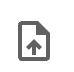

or by just dragging them onto the file browser area.

**However, you can also just save the images directly from the notebook via right-clicking.**

**Exercise**: Try to consolidate the code to define a prompt, use the "pipe" pipeline to generate an image, and display this image in the following (now still empty) code cell:

In [ ]:
#### Type here your code to:
##
## 1.) Define a variable "prompt", which contains a text prompt
## 2.) Generate an image via the pipeline, which is already stored in "pipe" 
## 3.) Display the image directly in the notebook
##
## Feel free to ask your coding-buddies or tutors for help at any time. :)



In [ ]:
#@title Click on "show code" for an exemplary solution

prompt = 'A teddy bear on a skateboard in Times Square. Highest quality. DSLR.'

image = pipe(prompt).images[0]

image

Running the above cell multiple times will give you a different image every time (**try it out** and **feel free to experiment with some other prompts**). If you want deterministic output you can pass a so called random "seed" to the pipeline. Every time you use the same seed you'll have the same image result.

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, generator=generator).images[0]

image

You can change the number of inference steps using the `num_inference_steps` argument. In general, results are better the more steps you use. Stable Diffusion, being one of the latest models, works great with a relatively small number of steps, so we recommend to use the default of `50`. If you want faster results you can use a smaller number.

The following cell uses the same seed as before, but with fewer steps. Note how some details are less realistic and less defined than in the previous image:

In [ ]:
import torch

generator = torch.Generator("cuda").manual_seed(1024)

image = pipe(prompt, num_inference_steps=15, generator=generator).images[0]

image

The other parameter in the pipeline call is `guidance_scale`. It is a way to increase the adherence to the conditional signal which in this case is text as well as overall sample quality. In simple terms classifier free guidance forces the generation to better match with the prompt. Numbers like `7` or `8.5` give good results, if you use a very large number the images might look good, but will be less diverse. 

You can learn about the technical details of this parameter in [the last section](https://colab.research.google.com/drive/1ALXuCM5iNnJDNW5vqBm5lCtUQtZJHN2f?authuser=1#scrollTo=UZp-ynZLrS-S) of this notebook.

To generate multiple images for the same prompt, we simply use a list with the same prompt repeated several times. We'll send the list to the pipeline instead of the string we used before.



Let's first write a helper function to display a grid of images. Just run the following cell to create the `image_grid` function, or disclose the code if you are interested in how it's done.

In [ ]:
#@title Create "image_grid" helper function

from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size
    
    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

Now, we can generate a grid image once having run the pipeline with a list of 3 prompts.

In [ ]:
num_images = 3
prompt = ["a photograph of an astronaut riding a horse"] * num_images

images = pipe(prompt).images

grid = image_grid(images, rows=1, cols=3)
grid

And here's how to generate a grid of `n × m` images.

In [ ]:
num_cols = 3
num_rows = 4

prompt = ["a photograph of an astronaut riding a horse"] * num_cols

all_images = []
for i in range(num_rows):
  images = pipe(prompt).images
  all_images.extend(images)

grid = image_grid(all_images, rows=num_rows, cols=num_cols)
grid

### Generate non-square images

Stable Diffusion produces images of `512 × 512` pixels by default. But it's very easy to override the default using the `height` and `width` arguments, so you can create rectangular images in portrait or landscape ratios.

These are some recommendations to choose good image sizes:
- Make sure `height` and `width` are both multiples of `8`.
- Going below 512 might result in lower quality images.
- Going over 512 in both directions will repeat image areas (global coherence is lost).
- The best way to create non-square images is to use `512` in one dimension, and a value larger than that in the other one.

In [ ]:
prompt = "a photograph of an astronaut riding a horse"

image = pipe(prompt, height=512, width=768).images[0]
image

## 2. What is Stable Diffusion

Now, let's go into the theoretical part of Stable Diffusion 👩‍🎓.

Stable Diffusion is based on a particular type of diffusion model called **Latent Diffusion**, proposed in [High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752).



General diffusion models are machine learning systems that are trained to *denoise* random gaussian noise step by step, to get to a sample of interest, such as an *image*. For a more detailed overview of how they work, check [this colab](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb).

Diffusion models have shown to achieve state-of-the-art results for generating image data. But one downside of diffusion models is that the reverse denoising process is slow. In addition, these models consume a lot of memory because they operate in pixel space, which becomes unreasonably expensive when generating high-resolution images. Therefore, it is challenging to train these models and also use them for inference.



<br>

Latent diffusion can reduce the memory and compute complexity by applying the diffusion process over a lower dimensional _latent_ space, instead of using the actual pixel space. This is the key difference between standard diffusion and latent diffusion models: **in latent diffusion the model is trained to generate latent (compressed) representations of the images.** 

There are three main components in latent diffusion.

1. An autoencoder (VAE).
2. A [U-Net](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/diffusers_intro.ipynb#scrollTo=wW8o1Wp0zRkq).
3. A text-encoder, *e.g.* [CLIP's Text Encoder](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**1. The autoencoder (VAE)**

The VAE model has two parts, an encoder and a decoder. The encoder is used to convert the image into a low dimensional latent representation, which will serve as the input to the *U-Net* model.
The decoder, conversely, transforms the latent representation back into an image.

 During latent diffusion _training_, the encoder is used to get the latent representations (_latents_) of the images for the forward diffusion process, which applies more and more noise at each step. During _inference_, the denoised latents generated by the reverse diffusion process are converted back into images using the VAE decoder. As we will see during inference we **only need the VAE decoder**.

**2. The U-Net**

The U-Net has an encoder part and a decoder part both comprised of ResNet blocks.
The encoder compresses an image representation into a lower resolution image representation and the decoder decodes the lower resolution image representation back to the original higher resolution image representation that is supposedly less noisy.
More specifically, the U-Net output predicts the noise residual which can be used to compute the predicted denoised image representation.

To prevent the U-Net from losing important information while downsampling, short-cut connections are usually added between the downsampling ResNets of the encoder to the upsampling ResNets of the decoder.
Additionally, the stable diffusion U-Net is able to condition its output on text-embeddings via cross-attention layers. The cross-attention layers are added to both the encoder and decoder part of the U-Net usually between ResNet blocks.

**3. The Text-encoder**

The text-encoder is responsible for transforming the input prompt, *e.g.* "An astronout riding a horse" into an embedding space that can be understood by the U-Net. It is usually a simple *transformer-based* encoder that maps a sequence of input tokens to a sequence of latent text-embeddings.

Inspired by [Imagen](https://imagen.research.google/), Stable Diffusion does **not** train the text-encoder during training and simply uses an CLIP's already trained text encoder, [CLIPTextModel](https://huggingface.co/docs/transformers/model_doc/clip#transformers.CLIPTextModel).

**Why is latent diffusion fast and efficient?**

Since the U-Net of latent diffusion models operates on a low dimensional space, it greatly reduces the memory and compute requirements compared to pixel-space diffusion models. For example, the autoencoder used in Stable Diffusion has a reduction factor of 8. This means that an image of shape `(3, 512, 512)` becomes `(3, 64, 64)` in latent space, which requires `8 × 8 = 64` times less memory.

This is why it's possible to generate `512 × 512` images so quickly, even on 16GB Colab GPUs!

**Stable Diffusion during inference**

Putting it all together, let's now take a closer look at how the model works in inference by illustrating the logical flow.


<p align="left">
<img src="https://raw.githubusercontent.com/patrickvonplaten/scientific_images/master/stable_diffusion.png" alt="sd-pipeline" width="500"/>
</p>

The stable diffusion model takes both a latent seed and a text prompt as an input. The latent seed is then used to generate random latent image representations of size $64 \times 64$ where as the text prompt is transformed to text embeddings of size $77 \times 768$ via CLIP's text encoder.

Next the U-Net iteratively *denoises* the random latent image representations while being conditioned on the text embeddings. The output of the U-Net, being the noise residual, is used to compute a denoised latent image representation via a scheduler algorithm. Many different scheduler algorithms can be used for this computation, each having its pros and cons. For Stable Diffusion, we recommend using one of:

- [PNDM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_pndm.py) (used by default)
- [DDIM scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py)
- [K-LMS scheduler](https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_lms_discrete.py)

Theory on how the scheduler algorithm function is out of scope for this notebook, but in short one should remember that they compute the predicted denoised image representation from the previous noise representation and the predicted noise residual.
For more information, we recommend looking into [Elucidating the Design Space of Diffusion-Based Generative Models](https://arxiv.org/abs/2206.00364)

The *denoising* process is repeated *ca.* 50 times to step-by-step retrieve better latent image representations.
Once complete, the latent image representation is decoded by the decoder part of the variational auto encoder.



After this brief introduction to Latent and Stable Diffusion, let's see how to make advanced use of 🤗 Hugging Face Diffusers!

## 3. How to write your own inference pipeline with `diffusers`

Finally, we show how you can create custom diffusion pipelines with `diffusers`.
This is often very useful to dig a bit deeper into certain functionalities of the system and to potentially switch out certain components. 

In this section, we will demonstrate how to use Stable Diffusion with a different scheduler, namely [Katherine Crowson's](https://github.com/crowsonkb) K-LMS scheduler that was added in [this PR](https://github.com/huggingface/diffusers/pull/185#pullrequestreview-1074247365).

Let's go through the `StableDiffusionPipeline` step by step to see how we could have written it ourselves.

We will start by loading the individual models involved.

In [ ]:
import torch
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

The [pre-trained model](https://huggingface.co/CompVis/stable-diffusion-v1-3-diffusers/tree/main) includes all the components required to setup a complete diffusion pipeline. They are stored in the following folders:
- `text_encoder`: Stable Diffusion uses CLIP, but other diffusion models may use other encoders such as `BERT`.
- `tokenizer`. It must match the one used by the `text_encoder` model.
- `scheduler`: The scheduling algorithm used to progressively add noise to the image during training.
- `unet`: The model used to generate the latent representation of the input.
- `vae`: Autoencoder module that we'll use to decode latent representations into real images.

We can load the components by referring to the folder they were saved, using the `subfolder` argument to `from_pretrained`.

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel, PNDMScheduler

# 1. Load the autoencoder model which will be used to decode the latents into image space. 
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# 2. Load the tokenizer and text encoder to tokenize and encode the text. 
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 3. The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

Now instead of loading the pre-defined scheduler, we load a K-LMS scheduler instead.

In [ ]:
from diffusers import LMSDiscreteScheduler

scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

Next we move the models to the GPU.

In [ ]:
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device) 

We now define the parameters we'll use to generate images.

Note that `guidance_scale` is defined analog to the guidance weight `w` of equation (2) in the [Imagen paper](https://arxiv.org/pdf/2205.11487.pdf). `guidance_scale == 1` corresponds to doing no classifier-free guidance. Here we set it to 7.5 as also done previously.

In contrast to the previous examples, we set `num_inference_steps` to 100 to get an even more defined image.

In [ ]:
prompt = ["a photograph of an astronaut riding a horse"]

height = 512                        # default height of Stable Diffusion
width = 512                         # default width of Stable Diffusion

num_inference_steps = 100            # Number of denoising steps

guidance_scale = 7.5                # Scale for classifier-free guidance

generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise

batch_size = 1

First, we get the text_embeddings for the prompt. These embeddings will be used to condition the UNet model.

In [ ]:
text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")

with torch.no_grad():
  text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

We'll also get the unconditional text embeddings for classifier-free guidance, which are just the embeddings for the padding token (empty text). They need to have the same shape as the conditional `text_embeddings` (`batch_size` and `seq_length`)

In [ ]:
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
)
with torch.no_grad():
  uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   

For classifier-free guidance, we need to do two forward passes. One with the conditioned input (`text_embeddings`), and another with the unconditional embeddings (`uncond_embeddings`). In practice, we can concatenate both into a single batch to avoid doing two forward passes.

In [ ]:
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

Generate the intial random noise.

In [ ]:
latents = torch.randn(
  (batch_size, unet.in_channels, height // 8, width // 8),
  generator=generator,
)
latents = latents.to(torch_device)

In [ ]:
latents.shape

Cool $64 \times 64$ is expected. The model will transform this latent representation (pure noise) into a `512 × 512` image later on.

Next, we initialize the scheduler with our chosen `num_inference_steps`.
This will compute the `sigmas` and exact time step values to be used during the denoising process.

In [ ]:
scheduler.set_timesteps(num_inference_steps)

The K-LMS scheduler needs to multiply the `latents` by its `sigma` values. Let's do this here

In [ ]:
latents = latents * scheduler.init_noise_sigma

We are ready to write the denoising loop.

Using `autocast` will run inference faster because it uses half-precision.

In [ ]:
from tqdm.auto import tqdm
from torch import autocast

for t in tqdm(scheduler.timesteps):
  # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
  latent_model_input = torch.cat([latents] * 2)

  latent_model_input = scheduler.scale_model_input(latent_model_input, t)

  # predict the noise residual
  with torch.no_grad():
    noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

  # perform guidance
  noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
  noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

  # compute the previous noisy sample x_t -> x_t-1
  latents = scheduler.step(noise_pred, t, latents).prev_sample

We now use the `vae` to decode the generated `latents` back into the image.

In [ ]:
# scale and decode the image latents with vae
latents = 1 / 0.18215 * latents

with torch.no_grad():
  image = vae.decode(latents).sample

And finally, let's convert the image to PIL so we can display or save it.

In [ ]:
image = (image / 2 + 0.5).clamp(0, 1)
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

Nice, as we can see the photo has quite a definition 🔥.